# HIDS 7006 - AI for Health Applications - Final Project
Fadwa Elfeituri (NetID: ffe7)

---

# Kaggle Model - Binary Classification of  Oral Cancer Detection  (Cancer vs Non-Cancer)

# Step 1 - Data Cleaning and Preparation (Kaggle_1 + Kaggle_2)

This notebook outlines the full data cleaning and preprocessing workflow for preparing oral cancer clinical images from two Kaggle datasets (Kaggle_1 and Kaggle_2). These images serve as input for a binary classification task (CANCER vs NON CANCER) in a downstream model. The objective of this notebook is to create a unified, standardized, and metadata-enriched dataset ready for training.

# Data Sources
The following datasets were used in this preprocessing pipeline:

* Kaggle_1 – [Oral Cancer Dataset](https://www.kaggle.com/datasets/zaidpy/oral-cancer-dataset/data): A collection of oral cancer images categorized into CANCER and NON CANCER.

* Kaggle_2 – [Oral Cancer: Lips & Tongue Dataset](https://www.kaggle.com/datasets/shivam17299/oral-cancer-lips-and-tongue-images?resource=download): Contains additional oral cavity images, particularly focused on specific regions such as the lips and tongue.

These datasets were sourced from publicly available Kaggle competitions and are intended for research and educational purposes only.

# Key Steps Included in This Notebook:

1. **Folder Normalization & Label Mapping**
    * Standardized inconsistent folder names across both datasets into two clean classes: CANCER and NON CANCER
    * Mapped various naming variations (e.g., non-cancer, noncancer) to unified class labels

2. **Data Merging & Flattening**
    * Merged Kaggle_1 and Kaggle_2 into a single structure (KaggleAll)
    * Flattened nested subfolders and prefixed image filenames with their source for traceability

3. **File Validation & Preview**
    * Validated image file extensions and flagged any unexpected formats
    * Displayed representative sample images from each class for sanity check

4. **Metadata Extraction**
    * Extracted properties like original and cleaned dimensions, image mode, format, and file size
    * Built a structured manifest linking each image path with its label and metadata

5. **Image Preprocessing & Standardization**
    * Resized all images to 128x128 pixels and saved them as JPEGs
    * Converted all color modes to RGB for consistency
    * Saved cleaned images into a dedicated KaggleAll_clean folder structure by class

6. **Feature Engineering**
    * Computed derived features such as:
        * Aspect ratios (original and cleaned)
        * Scaling factor (image area change during resizing)
        * File size in kilobytes
        * One-hot encoded mode and format attributes
        * Scaled continuous features using z-score normalization

In [ ]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Umport Libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import shutil
import re
from tqdm import tqdm
from pathlib import Path
from collections import Counter
from sklearn.preprocessing import StandardScaler
from utils.preprocessing import extract_image_metadata, engineer_features, save_manifest



1. **Folder Normalization & Label Mapping**
    * Standardized inconsistent folder names across both datasets into two clean classes: CANCER and NON CANCER
    * Mapped various naming variations (e.g., non-cancer, noncancer) to unified class labels


In [ ]:
# Print the number of image files in each class subfolder under Kaggle_1
base = Path('/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Datasets/Raw/Clinical_Images/Kaggle_1')   # adjust to your Kaggle_1 path
for subset in base.iterdir():
    if not subset.is_dir():
        continue
    for label in subset.iterdir():
        if not label.is_dir():
            continue
        n = sum(1 for _ in label.glob('*') if _.is_file())
        print(f"{subset.name!r} → {label.name!r} : {n} files")

'oral_cancer_dataset' → 'NON CANCER' : 250 files
'oral_cancer_dataset' → 'CANCER' : 500 files
'oc_dataset_kaggle_new' → 'CANCER' : 490 files
'oc_dataset_kaggle_new' → 'NON CANCER' : 450 files


In [ ]:
# Print the number of image files in each class subfolder under Kaggle_2
base = Path('/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Datasets/Raw/Clinical_Images/Kaggle_2')
for subset in base.iterdir():
    if not subset.is_dir():
        continue
    for label in subset.iterdir():
        if not label.is_dir():
            continue
        n = sum(1 for _ in label.glob('*') if _.is_file())
        print(f"{subset.name!r} → {label.name!r} : {n} files")

'OralCancer' → 'cancer' : 87 files
'OralCancer' → 'non-cancer' : 44 files


In [ ]:
# Define each source root (kaggle1 and kaggle2)
roots = {
    'kaggle1': Path('/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Datasets/Raw/Clinical_Images/Kaggle_1'),
    'kaggle2': Path('/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Datasets/Raw/Clinical_Images/Kaggle_2'),
}

# Normalize all possible folder‐name variants into 'CANCER' / 'NON CANCER'
label_map = {
    'cancer':     'CANCER',
    'non cancer': 'NON CANCER',
    'non-cancer': 'NON CANCER',
    'non_cancer': 'NON CANCER',
    'noncancer':  'NON CANCER',
}
# Count how many images per (source, label) and flag any unexpected folders
found = Counter()
skipped = Counter()

for source, root in roots.items():
    for img in root.rglob('*'):
        if not img.is_file():
            continue
        raw = img.parent.name.strip()
        key = raw.lower().replace('_',' ').replace('-',' ')
        lbl = label_map.get(key)
        if lbl:
            found[(source, lbl)] += 1
        else:
            skipped[key] += 1

print("✔️ Found images by source & class:")
for (src,lbl),cnt in found.items():
    print(f"   {src:7s} → {lbl:10s}: {cnt}")
print("\n⚠️  Skipped folders (i.e. unexpected parent names):")
for k,v in skipped.items():
    print(f"   '{k}': {v} files")

✔️ Found images by source & class:
   kaggle1 → NON CANCER: 700
   kaggle1 → CANCER    : 990
   kaggle2 → CANCER    : 87
   kaggle2 → NON CANCER: 44

⚠️  Skipped folders (i.e. unexpected parent names):
   'kaggle 1': 1 files
   'kaggle 2': 1 files


2. **Data Merging & Flattening**
    * Merged Kaggle_1 and Kaggle_2 into a single structure (KaggleAll)
    * Flattened nested subfolders and prefixed image filenames with their source for traceability

In [ ]:
# Flatten and merge Kaggle_1 and Kaggle_2 into a single directory structure
# under KaggleAll, with only two folders: CANCER and NON CANCER.

# 1) Define the original dataset roots:
kaggle1_root = Path(
    '/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Datasets/Raw/Clinical_Images/Kaggle_1'
)
kaggle2_root = Path(
    '/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Datasets/Raw/Clinical_Images/Kaggle_2/OralCancer'
)

# 2) Define the destination for the flattened dataset:
dest = Path(
    '/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Datasets/Raw/Clinical_Images/KaggleAll'
)

# 3) Create the two target class folders (if they don't already exist):
for label in ['CANCER', 'NON CANCER']:
    (dest/label).mkdir(parents=True, exist_ok=True)

# 4) Helper function to copy all images from a given source into the flat structure:
def flatten_source(root: Path, prefix: str):
    """
    Walks through `root`, detects whether images are directly in subfolders
    (as in Kaggle_2) or nested one level deeper (as in Kaggle_1), and copies
    each image into dest/{CANCER,NON CANCER}, prefixing filenames with the source.
    """
    for subset in root.iterdir():
        if not subset.is_dir():
            continue
        # If this folder contains images itself, treat it as a class folder:
        if any(f.suffix.lower() in ('.jpg','.jpeg','.png') for f in subset.iterdir()):
            label = subset.name.upper().replace('-', ' ')  # map 'cancer'→'CANCER', 'non-cancer'→'NON CANCER'
            target = dest/label
            for img in subset.iterdir():
                if img.suffix.lower() not in ('.jpg','.jpeg','.png'):
                    continue
                shutil.copy(img, target/f"{prefix}_{img.name}")
        # Otherwise, assume this is a container of CANCER & NON CANCER subfolders:
        else:
            for cls in subset.iterdir():
                if not cls.is_dir():
                    continue
                label = cls.name  # should be 'CANCER' or 'NON CANCER'
                target = dest/label
                for img in cls.iterdir():
                    if img.suffix.lower() not in ('.jpg','.jpeg','.png'):
                        continue
                    shutil.copy(img, target/f"{prefix}_{subset.name}_{img.name}")

# 5) Run the flattening for both Kaggle sources:
flatten_source(kaggle1_root, 'kaggle1')
flatten_source(kaggle2_root, 'kaggle2')

# 6) Sanity-check final image counts:
for label in ['CANCER','NON CANCER']:
    n = len(list((dest/label).glob('*')))
    print(f"{label}: {n} images")

CANCER: 1077 images
NON CANCER: 744 images


3. **File Validation & Preview**
    * Validated image file extensions and flagged any unexpected formats
    * Displayed representative sample images from each class for sanity check

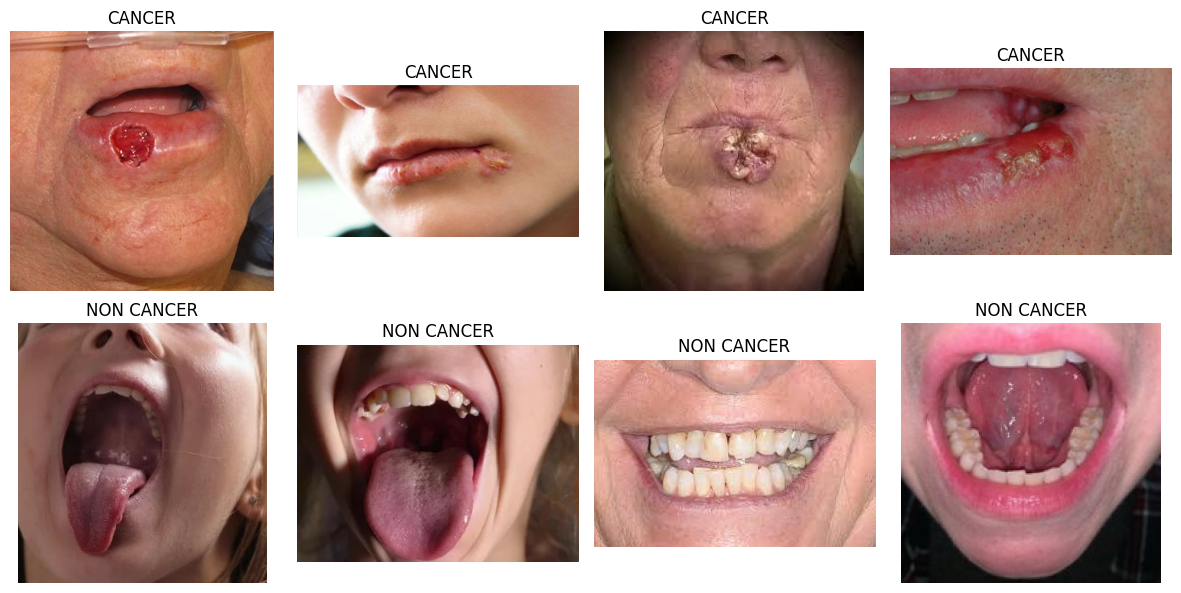

In [ ]:
# Display a few example images per class from the flattened dataset
def preview_samples(root, labels=('CANCER','NON CANCER'), n_per_label=4):
    fig, axes = plt.subplots(len(labels), n_per_label, figsize=(n_per_label*3, len(labels)*3))
    for i, label in enumerate(labels):
        files = list((root/label).glob('*'))[:n_per_label]
        for j, fp in enumerate(files):
            img = Image.open(fp).convert('RGB')
            axes[i,j].imshow(img)
            axes[i,j].axis('off')
            axes[i,j].set_title(label)
    plt.tight_layout()
    plt.show()

preview_samples(Path("/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Datasets/Raw/Clinical_Images/KaggleAll"))

4. **Metadata Extraction**
    * Extracted properties like original and cleaned dimensions, image mode, format, and file size
    * Built a structured manifest linking each image path with its label and metadata

In [ ]:
# Gather metadata for every image—path, label, dimensions, color mode, and file format—and compute per‑class stats
root = Path('/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Datasets/Raw/Clinical_Images/KaggleAll')
records = []

for label in ['CANCER','NON CANCER']:
    for img_path in (root/label).glob('*'):
        try:
            with Image.open(img_path) as img:
                records.append({
                    'path':    str(img_path),
                    'label':   label,
                    'width':   img.width,
                    'height':  img.height,
                    'mode':    img.mode,
                    'format':  img.format
                })
        except Exception as e:
            print(f'⚠️ Corrupted or unreadable: {img_path}')

df = pd.DataFrame(records)
print("Total images recorded:", len(df))
print(df.groupby('label').size(), "\n")

# Show dimension stats per class
stats = df.groupby('label').agg({
    'width':  ['mean','min','max'],
    'height': ['mean','min','max']
})
print(stats)

Total images recorded: 1821
label
CANCER        1077
NON CANCER     744
dtype: int64 

                 width                height          
                  mean min   max        mean min   max
label                                                 
CANCER      657.980501  93  9248  577.517177  96  6936
NON CANCER  793.893817  90  5461  846.580645  89  4032


In [ ]:
# Inspect and validate all image file extensions
root = Path("/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Datasets/Raw/Clinical_Images/KaggleAll")

# 5.1) Count each extension in the dataset
ext_counts = Counter(p.suffix.lower() for p in root.rglob("*") if p.is_file())
print("Found extensions and counts:")
for ext, cnt in ext_counts.most_common():
    print(f"  {ext or '<no suffix>'}: {cnt}")

# 5.2) Flag any files with unexpected extensions
valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
bad = [p for p in root.rglob("*") if p.is_file() and p.suffix.lower() not in valid_exts]
if bad:
    print("\n⚠️  These files have unexpected extensions:")
    for p in bad:
        print("   ", p.relative_to(root))
else:
    print("\n✅  All files have valid extensions.")

Found extensions and counts:
  .jpeg: 1704
  .jpg: 100
  .png: 17

✅  All files have valid extensions.



5. **Image Preprocessing & Standardization**
    * Resized all images to 128x128 pixels and saved them as JPEGs
    * Converted all color modes to RGB for consistency
    * Saved cleaned images into a dedicated KaggleAll_clean folder structure by class


In [ ]:
# Configure input/output paths and image parameters
RAW_ROOT     = Path('/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Datasets/Raw/Clinical_Images/KaggleAll')
CLEAN_ROOT   = Path('/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Datasets/Processed/Clinical_Images/KaggleAll_clean')
TARGET_SIZE  = (128, 128)    # Width × height for all output images
JPEG_QUALITY = 80            # JPEG quality (0–100) for saved files

# Ensure output class directories exist
for label in ['CANCER', 'NON CANCER']:
    (CLEAN_ROOT / label).mkdir(parents=True, exist_ok=True)

In [ ]:
# Preprocess every image and build a metadata‑rich manifest
records = []

for label, idx in [('CANCER',1), ('NON CANCER',0)]:
    (CLEAN_ROOT/label).mkdir(parents=True, exist_ok=True)
    for src in tqdm(list((RAW_ROOT/label).glob('*')), desc=f"Process {label}"):
        try:
            with Image.open(src) as raw:
                ow, oh = raw.size
                mode   = raw.mode
                fmt    = raw.format

                img = raw.convert('RGB')
                img = img.resize(TARGET_SIZE, Image.LANCZOS)

                dst = CLEAN_ROOT/label/f"{src.stem}.jpg"
                img.save(dst, format='JPEG', quality=JPEG_QUALITY, optimize=True)

                # record post‑processing metadata
                clean_mode   = img.mode        # should be "RGB"
                clean_format = 'JPEG'

                records.append({
                    'filepath':      str(dst),
                    'label':         label,
                    'label_idx':     idx,
                    'orig_width':    ow,
                    'orig_height':   oh,
                    'clean_width':   img.width,
                    'clean_height':  img.height,
                    'orig_mode':     mode,
                    'orig_format':   fmt,
                    'clean_mode':    clean_mode,
                    'clean_format':  clean_format
                })
        except Exception as e:
            print(f"⚠️ Skipped {src.name}: {e}")

df = pd.DataFrame(records)
manifest = '/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Datasets/Processed/Clinical_Images/manifest_kaggleAll.csv'
df.to_csv(manifest, index=False)
print("✅ Written enriched manifest:", manifest)

Process CANCER:   1%|          | 12/1077 [00:07<07:19,  2.43it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Process NON CANCER: 100%|██████████| 744/744 [04:12<00:00,  2.95it/s]


✅ Written enriched manifest: /content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Datasets/Processed/Clinical_Images/manifest_kaggleAll.csv


6. **Feature Engineering**
    * Computed derived features such as:
        * Aspect ratios (original and cleaned)
        * Scaling factor (image area change during resizing)
        * File size in kilobytes
        * One-hot encoded mode and format attributes
        * Scaled continuous features using z-score normalization

In [ ]:
# Engineer new features from the manifest

# 1) load enriched manifest
df = pd.read_csv(
    '/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/'
    'Project/Datasets/Processed/Clinical_Images/manifest_kaggleAll.csv'
)

# 2) file‐size (bytes & KB)
df['filesize_bytes'] = df['filepath'].apply(lambda p: Path(p).stat().st_size)
df['filesize_kb']    = df['filesize_bytes'] / 1024

# 3) aspect ratios
df['clean_ar'] = df['clean_width']  / df['clean_height']
df['orig_ar']  = df['orig_width']   / df['orig_height']

# 4) scale factor (area ratio)
df['scale_factor'] = (
    df['clean_width'] * df['clean_height']
) / (df['orig_width'] * df['orig_height'])

# 5) one‐hot encode all four mode/format columns
df = pd.get_dummies(
    df,
    columns=['orig_mode','orig_format','clean_mode','clean_format'],
    drop_first=True
)

# 5.5) Convert boolean columns to 0/1
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# 6) Scale continuous variables
num_cols = [
    'orig_width','orig_height',
    'clean_width','clean_height',
    'filesize_kb','clean_ar','orig_ar','scale_factor'
]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
# Export Manifest file
df.to_csv('/content/drive/MyDrive/Georgetown University/HIDS/Spring-25/HIDS-7006/Project/Datasets/Processed/Clinical_Images/manifest+features_kaggleAll.csv', index=False)

### Modular Version (Reusable Script)

Below is a cleaner version of the same pipeline using a reusable script located at `utils/preprocessing.py`. This mirrors the logic in the steps above.


In [ ]:
# df_script = extract_image_metadata("data/raw")
# df_script = engineer_features(df_script)
#save_manifest(df_script, out_path="manifests/image_metadata_manifest.csv")